In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data=pd.read_csv('/content/drive/MyDrive/SO2_MODIFIED.csv')
data

,TimeStamp,3207010,33204020,29209010,33202110,14104030,8344010,43202020,34202020,28209010,...,23211040,12201160,11222020,15201150,27201030,20202050,5203020,34207090,27210010,44214010
0,2018-01-01 00:00:00,0.000,0.005,0.003,0.003,0.002,0.0,0.000,0.001,0.001,...,0.000,0.001,0.000,0.001,0.006,0.003,0.000,0.001,0.0,0.002
1,2018-01-01 01:00:00,0.000,0.005,0.003,0.003,0.002,0.0,0.000,0.001,0.001,...,0.000,0.001,0.000,0.001,0.006,0.003,0.000,0.001,0.0,0.002
2,2018-01-01 02:00:00,0.000,0.005,0.003,0.003,0.005,0.0,0.000,0.001,0.001,...,0.000,0.000,0.000,0.001,0.004,0.003,0.000,0.001,0.0,0.003
3,2018-01-01 03:00:00,0.000,0.007,0.002,0.004,0.005,0.0,0.000,0.001,0.001,...,0.000,0.000,0.000,0.001,0.004,0.003,0.001,0.001,0.0,0.003
4,2018-01-01 04:00:00,0.000,0.004,0.002,0.003,0.004,0.0,0.001,0.001,0.001,...,0.000,0.000,0.000,0.000,0.004,0.003,0.001,0.001,0.0,0.003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51115,2023-10-31 19:00:00,0.001,0.001,0.001,0.006,0.003,0.0,0.001,0.001,0.001,...,0.001,0.001,0.002,0.000,NaN,0.000,0.000,0.001,NaN,0.001
51116,2023-10-31 20:00:00,0.000,0.001,0.000,0.004,0.003,0.0,0.000,0.000,0.000,...,0.001,0.001,0.002,0.000,NaN,0.000,0.000,0.001,NaN,0.001
51117,2023-10-31 21:00:00,0.000,0.001,0.000,0.004,0.003,0.0,0.000,0.001,0.001,...,0.000,0.001,0.002,0.000,NaN,0.000,0.000,0.001,NaN,0.001
51118,2023-10-31 22:00:00,0.001,0.001,0.000,0.003,0.004,0.0,0.000,0.001,0.001,...,0.000,0.001,0.001,0.000,NaN,0.000,0.000,0.000,NaN,0.002


In [4]:
import tensorflow as tf

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
#Load the datset
dataset=pd.read_csv('/content/drive/MyDrive/SO2_MODIFIED.csv')

#selectt the column 'v for the prediction
selected_col= '29209010'

In [6]:
train_data, test_data = train_test_split(dataset[selected_col], test_size=0.2, shuffle=False)

#define the forcasting horiz
forecast_horizon = 24

In [7]:
#function to prepare input features and target variables
def prepare_data_for_forcasting(data, forecasting_horizon):
  x,y =[],[]
  for i in range(len(data)-forecast_horizon):
    x.append(data[i:(i+forecast_horizon)])
    y.append(data[i+forecast_horizon])
  return np.array(x), np.array(y)

In [8]:
#preapare input features and target variables for traing and testing
x_train, y_train = prepare_data_for_forcasting(train_data.values, forecast_horizon)
x_test, y_test = prepare_data_for_forcasting(test_data.values, forecast_horizon)

#reshape the data for trasformer model input
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1) # Removed the extra reshape call

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0,name="transformer_encoder"):
  # Print the shape of the inputs to check if it's defined
  print("Shape of inputs to transformer_encoder:", inputs.shape)
  x=tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs)
  x=tf.keras.layers.MultiHeadAttention(
      num_heads=num_heads,
      key_dim=head_size,
      dropout=dropout
  )(x,x)
  x=tf.keras.layers.Dropout(dropout)(x)
  res=x+inputs
  return res

In [9]:
def build_model(input_shape,head_size,num_heads,ff_dim,num_transformer_blocks,mlp_units,dropout=0,mlp_dropout=0):

    inputs=tf.keras.layers.Input(shape=input_shape)
    x=inputs
    for _ in range(num_transformer_blocks):
        x=transformer_encoder(x,head_size,num_heads,ff_dim,dropout)
    x=tf.keras.layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x=tf.keras.layers.Dense(dim,activation='relu')(x)
        x=tf.keras.layers.Dropout(mlp_dropout)(x)
    outputs=tf.keras.layers.Dense(1,activation="relu")(x)
    return tf.keras.Model(inputs,outputs)

In [10]:
# Set hyperparameters
input_shape = x_train.shape[1:]
head_size = 256
num_heads = 4
ff_dim = 256
num_transformer_blocks = 2
mlp_units = [256]
dropout = 0.2
mlp_dropout = 0.4

In [11]:
# Build the model
input_shape = x_train.shape[1:]
head_size = 256
num_heads = 4
ff_dim = 256
num_transformer_blocks = 2
mlp_units = [256]
dropout = 0.2
mlp_dropout = 0.4

# Build the model
model = build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout, mlp_dropout)
# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model with reduced epochs (10 epochs)
history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.1)

# Make predictions on the test data
predictions = model.predict(x_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("Root Mean Squared Error (RMSE):", rmse)

Shape of inputs to transformer_encoder: (None, 24, 1)
Shape of inputs to transformer_encoder: (None, 24, 1)
Epoch 1/10
575/575 [==============================] - 128s 216ms/step - loss: 8.7789e-06 - val_loss: 1.0697e-06
Epoch 2/10
575/575 [==============================] - 120s 209ms/step - loss: 8.5629e-06 - val_loss: 1.0697e-06
Epoch 3/10
575/575 [==============================] - 124s 216ms/step - loss: 8.5375e-06 - val_loss: 1.0697e-06
Epoch 4/10
575/575 [==============================] - 128s 222ms/step - loss: 8.5375e-06 - val_loss: 1.0697e-06
Epoch 5/10
575/575 [==============================] - 121s 210ms/step - loss: 8.5375e-06 - val_loss: 1.0697e-06
Epoch 6/10
575/575 [==============================] - 124s 216ms/step - loss: 8.5375e-06 - val_loss: 1.0697e-06
Epoch 7/10
575/575 [==============================] - 120s 208ms/step - loss: 8.5375e-06 - val_loss: 1.0697e-06
Epoch 8/10
575/575 [==============================] - 127s 221ms/step - loss: 8.5375e-06 - val_loss: 1.0697e

Epoch 1/10
575/575 [==============================] - 137s 238ms/step - loss: 8.5375e-06 - val_loss: 1.0697e-06
Epoch 2/10
575/575 [==============================] - 122s 211ms/step - loss: 8.5375e-06 - val_loss: 1.0697e-06
Epoch 3/10
575/575 [==============================] - 128s 222ms/step - loss: 8.5375e-06 - val_loss: 1.0697e-06
Epoch 4/10
575/575 [==============================] - 121s 211ms/step - loss: 8.5375e-06 - val_loss: 1.0697e-06
Epoch 5/10
575/575 [==============================] - 124s 215ms/step - loss: 8.5375e-06 - val_loss: 1.0697e-06
Epoch 6/10
575/575 [==============================] - 123s 215ms/step - loss: 8.5375e-06 - val_loss: 1.0697e-06
Epoch 7/10
575/575 [==============================] - 125s 217ms/step - loss: 8.5375e-06 - val_loss: 1.0697e-06
Epoch 8/10
575/575 [==============================] - 122s 212ms/step - loss: 8.5375e-06 - val_loss: 1.0697e-06
Epoch 9/10
575/575 [==============================] - 124s 216ms/step - loss: 8.5375e-06 - val_loss: 1.0

NameError: name 'selected_column' is not defined

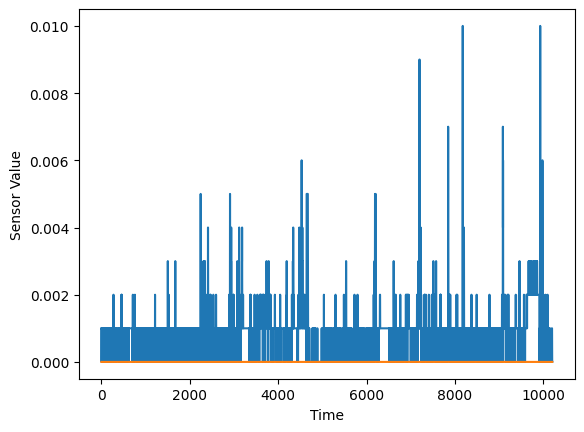

In [12]:
history=model.fit(x_train,y_train,epochs=10,batch_size=64,validation_split=0.1)

predictions=model.predict(x_test)
mse=mean_squared_error(y_test,predictions)
print("MSE:",mse)
rmse=np.sqrt(mean_squared_error(y_test,predictions))


Root Mean Squared Error  0.001099375937057198


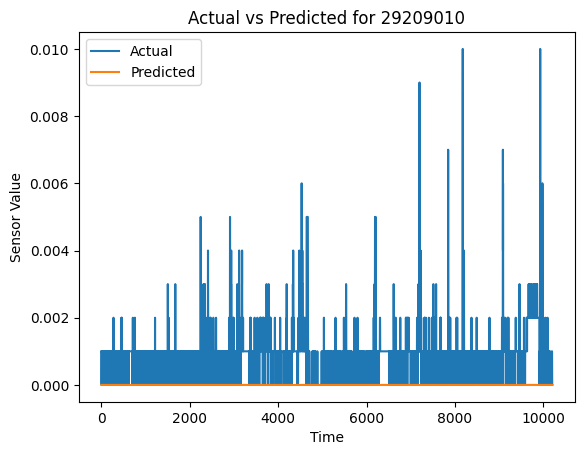

In [13]:
print("Root Mean Squared Error ",rmse)
plt.plot(y_test,label="Actual")
plt.plot(predictions,label="Predicted")
plt.xlabel("Time")
plt.ylabel("Sensor Value")
plt.title("Actual vs Predicted for {}".format(selected_col))
plt.legend()
plt.show()
